In [1]:
import xarray
import fsspec
import numpy as np
import s3fs
import proplot
import os

from matplotlib import pyplot as plt
import pandas

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
def create_profile_index(wod_dataset,variable_name):
    
    cast_row_size = wod_dataset[variable_name + '_row_size'].values
    
    
    cast_counter = cast_row_size.cumsum().astype(int)
    
    cast_counter = np.concatenate([np.zeros([1],dtype=int),cast_counter])
    cast_index   = xarray.full_like(wod_dataset[variable_name + '_obs'],fill_value=0,dtype=int)
    
    #unique_cast_for_variable = 
    cast_row_counter = 0
    for i_cast in range(0,wod_dataset['casts'].size):

        current_cast_row_size = cast_row_size[i_cast] #.astype(int)
        #print(current_cast_row_size)
        if not np.isnan(current_cast_row_size):
            
            
            cast_index[cast_row_counter:cast_row_counter+int(current_cast_row_size)] =  wod_dataset['casts'][i_cast].astype(int)
            cast_row_counter = cast_row_counter + int(current_cast_row_size)
            
            
    return cast_index

In [3]:
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 50})
    return s3fs.S3Map(path, s3=fs)

In [4]:
START_YEAR = 2018
END_YEAR   = 2018

#year = 2018
obs_type = ['ctd','xbt','pfl','mrb','gld','drb'] #,'gld']
base_s3_url = 's3://noaa-wod-pds'

data_container = {}

for i_year in range(START_YEAR,END_YEAR+1):

    data_container_for_year = {}
    for i_obs_type in obs_type:
        url = base_s3_url + '/' + str(i_year) + '/wod_' + i_obs_type + '_' + str(i_year) + '.nc' #_pfl_2018.nc'
        print(url)
        fs = s3fs.S3FileSystem(anon=True)
        file_obj = fs.open(url)
        ds = xarray.open_dataset(file_obj,engine='h5netcdf')
        data_container_for_year[i_obs_type] = ds
        
    data_container[i_year] = data_container_for_year

#ds.air_temperature_at_2_metres.encoding


s3://noaa-wod-pds/2018/wod_ctd_2018.nc
s3://noaa-wod-pds/2018/wod_xbt_2018.nc
s3://noaa-wod-pds/2018/wod_pfl_2018.nc
s3://noaa-wod-pds/2018/wod_mrb_2018.nc
s3://noaa-wod-pds/2018/wod_gld_2018.nc
s3://noaa-wod-pds/2018/wod_drb_2018.nc


In [ ]:
variable_name = 'Temperature'

for i_year in range(START_YEAR,END_YEAR+1):
   
    for i_obs_type in obs_type:

        print(i_obs_type)
        cast_temperature_index = create_profile_index(data_container[i_year][i_obs_type],variable_name)
        cast_depth_index       = create_profile_index(data_container[i_year][i_obs_type],'z')
        #dsadsa
        data_container[i_year][i_obs_type][variable_name + '_cast_index'] = cast_temperature_index
        data_container[i_year][i_obs_type]['z_cast_index']                = cast_depth_index

ctd
xbt
pfl


In [18]:
LONGITUDE_LIM_WEST = 90
LONGITUDE_LIM_EAST = 180

LATITUDE_LIM_SOUTH = -50
LATITUDE_LIM_NORTH =   0

DELTA_LON = 0.05
DELTA_LAT = 0.05
pressure_levels_interp = np.arange(2000,-1,-50)

#obs_type = ['ctd','xbt','pfl','osd','mrb','gld','drb'] #,'gld']


year_to_get = 2018
#i_year_to_get = year_to_get-START_YEAR

data_container_for_year = data_container[year_to_get]
obs_type = ['ctd','xbt','pfl','mrb','gld','drb']

longitude_grid = np.arange(LONGITUDE_LIM_EAST,LONGITUDE_LIM_EAST+0.5*DELTA_LON,DELTA_LON)
latitude_grid  = np.arange(LATITUDE_LIM_SOUTH,LATITUDE_LIM_NORTH+0.5*DELTA_LAT,DELTA_LON)

#lonr = -270.:dx:-180.; # the range of longitudes (start:step:end)
#latr = -50.:dy:0.;

for i_obs_type in ['pfl']:
    
    print(i_obs_type)
    meets_condition = ( (data_container_for_year[i_obs_type]['lat']>=LATITUDE_LIM_SOUTH) & (data_container_for_year[i_obs_type]['lat']<=LATITUDE_LIM_NORTH) 
                      & (data_container_for_year[i_obs_type]['lon']>=LONGITUDE_LIM_WEST) & (data_container_for_year[i_obs_type]['lon']<=LONGITUDE_LIM_EAST)  ) 


    casts_in_box = data_container_for_year[i_obs_type]['casts'][meets_condition]

    if meets_condition.sum() != 0:
        temperature_casts_to_get           = data_container_for_year[i_obs_type]['Temperature_cast_index'].isin(casts_in_box)
        temperature_for_casts              = data_container_for_year[i_obs_type]['Temperature'][temperature_casts_to_get]
        temperature_cast_index_for_cast    = data_container_for_year[i_obs_type]['Temperature_cast_index'][temperature_casts_to_get]

        latitude_for_casts                 = data_container_for_year[i_obs_type]['lat'].sel(casts=temperature_cast_index_for_cast)
        longitude_for_casts                = data_container_for_year[i_obs_type]['lon'].sel(casts=temperature_cast_index_for_cast)
        time_for_casts                     = data_container_for_year[i_obs_type]['time'].sel(casts=temperature_cast_index_for_cast)
 
        z_casts_to_get                     = data_container_for_year[i_obs_type]['z_cast_index'].isin(temperature_cast_index_for_cast)
        z_for_casts                        = data_container_for_year[i_obs_type]['z'][z_casts_to_get]
        z_cast_index_for_cast              = data_container_for_year[i_obs_type]['z_cast_index'][z_casts_to_get]

        interp_temperature = interp_to_pressure_levels(temperature_for_casts,temperature_cast_index_for_cast,z_for_casts,z_cast_index_for_cast,pressure_levels_interp)
        
        
        
        
        
        
        
        #variable_output_dataarray = xarray.DataArray(latitude_for_casts,dims=['Temperature_obs'],coords={'Temperature_obs':latitude_for_casts['Temperature_obs']}).to_dataset(name='lat')
        #variable_output_dataarray['lon'] = xarray.DataArray(longitude_for_casts,dims=['Temperature_obs'],coords={'Temperature_obs':longitude_for_casts['Temperature_obs']})
        #variable_output_dataarray['time'] = xarray.DataArray(time_for_casts,dims=['Temperature_obs'],coords={'Temperature_obs':time_for_casts['Temperature_obs']})
        #variable_output_dataarray['Temperature'] = xarray.DataArray(temperature_for_casts,dims=['Temperature_obs'],coords={'Temperature_obs':time_for_casts['Temperature_obs']})
        #variable_output_dataarray['z'] = xarray.DataArray(z_for_casts,dims=['Temperature_obs'],coords={'Temperature_obs':time_for_casts['Temperature_obs']})
    
        #variable_output_dataarray.to_netcdf('/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/WOD_' +str(year_to_get) + '_Temperature_' + obs_type_label[i_obs_type] + '.nc')

pfl
6
11
19
20
26
33
39
49
50
54
56
59
63
87
93
104
105
142
152
168
171
176
180
181
186
230
252
272
291
309
323
346
361
376
389
393
409
410
420
427
428
429
436
440
455
464
471
474
482
485
488
490
491
507
510
520
536
546
570
577
604
608
609
615
623
626
630
646
674
710
719
732
748
752
785
792
824
827
841
843
852
854
862
906
909
915
919
922
923
936
954
957
961
968
976
989
991
1024
1035
1046
1050
1072
1073
1077
1082
1094
1098
1126
1140
1143
1170
1173
1175
1201
1225
1236
1245
1265
1275
1276
1291
1307
1317
1327
1330
1332
1336
1347
1396
1397
1400
1402
1414
1428
1430
1435
1443
1450
1461
1466
1479
1480
1499
1500
1510
1524
1525
1534
1535
1588
1604
1611
1639
1658
1668
1678
1681
1683
1702
1710
1713
1720
1721
1733
1734
1735
1744
1752
1753
1757
1758
1771
1775
1783
1785
1789
1795
1806
1811
1828
1836
1839
1848
1871
1890
1891
1899
1902
1903
1904
1910
1922
1934
2001
2004
2005
2008
2011
2019
2020
2021
2030
2039
2068
2092
2126
2130
2139
2164
2173
2187
2189
2198
2201
2202
2207
2211
2213
2214
2226
2230
2253

FSTimeoutError: 

In [58]:
def gsw_data_interp(data,p,p_i,scale_factor=0.33):
    
    import gsw as TEOS_10
    
    
    number_of_profiles,_  = data.shape
    interp_profile_length = p_i.shape[0]

    
    

    
     
    
    #scale_factor = 0.33
    #CT_obs = gsw_CT_from_t(gsw_SSO*ones(size(t_obs)),t_obs,p_obs)
    #CT_i = gsw_data_interp(CT_obs,p_obs,p_i_tmp,scale_factor);
    #t_i(:,Iprofile) = gsw_t_from_CT(gsw_SSO*ones(size(CT_i)),CT_i,p_i_tmp);
    
    sin_pi_on_16  = 1.950903220161283e-1;  # %sin_pi_on_16 = sin(pi./16)
    cos_pi_on_16  = 9.807852804032304e-1;  # %cos_pi_on_16 = cos(pi./16)
    sin_pi_on_8   = 3.826834323650898e-1;  # %sin_pi_on_8 = sin(pi./8)
    cos_pi_on_8   = 9.238795325112867e-1;  # %cos_pi_on_8 = cos(pi./8)
    sin_3pi_on_16 = 5.555702330196022e-1;  # %sin_3pi_on_16 = sin(3pi./16)
    cos_3pi_on_16 = 8.314696123025452e-1;  # %cos_3pi_on_16 = cos(3pi./16)
    sin_pi_on_4   = 7.071067811865475e-1;  # %sin_pi_on_8 = sin(pi./4)
    cos_pi_on_4   = 7.071067811865476e-1;  # %cos_pi_on_8 = cos(pi./4)
    sin_5pi_on_16 = 8.314696123025452e-1;  # %sin_pi_on_8 = sin(5pi./16)
    cos_5pi_on_16 = 5.555702330196023e-1;  # %cos_pi_on_8 = cos(5pi./16)
    sin_3pi_on_8  = 9.238795325112867e-1;  # %sin_pi_on_8 = sin(3pi./8)
    cos_3pi_on_8  = 3.826834323650898e-1;  # %cos_pi_on_8 = cos(3pi./8)
    sin_7pi_on_16 = 9.807852804032304e-1;  # %sin_pi_on_8 = sin(7pi./16)
    cos_7pi_on_16 = 1.950903220161283e-1;  # %cos_pi_on_8 = cos(7pi./16)
    
    for i_profile in range(0,number_of_profiles):
        
        p_obs = p[i_profile,:]
        data_obs = t[i_profile,:]
        
        
        idx_shallow = np.arange(0,p_obs.size-1)
        idx_deep = np.arange(1,p_obs.size)
        
        dp_tmp = p_obs(idx_deep) - p_obs(idx_shallow);
        
        independent_variable     = np.arange(0,p_profile.size-1,1)
        independent_variable_i   = TEOS_10.pchip_interp(independent_variable,p_obs,p_i)
        
        
        ddata_tmp = data_obs(idx_deep) - data_obs(idx_shallow)
        axes_scale_factor = scale_factor * np.max(abs(ddata_tmp));
        
        #dummy = 
        tor = axes_scale_factor * np.arange(0,p_obs.size)
    
        v1_tmp = data_obs;
        q1_tmp = tor;
        v1_i,q1_i = pchip_interp_SA_CT(v1_tmp,q1_tmp,independent_variable,independent_variable_i);
    
        
        
        

        
    
    
    return t_i
    

    

SyntaxError: invalid syntax (2594117279.py, line 54)

In [17]:
def interp_to_pressure_levels(data,data_cast_index,pressure,pressure_cast_index,pressure_levels_interp):
    import gsw as TEOS_10

    min_obs_for_interp = 4

    unique_cast_identifer = np.unique(data_cast_index)
    
    data_interp  = np.zeros([unique_cast_identifer.size,pressure_levels_interp.size],dtype=np.float32)
    cast_counter = 0
    for i_cast in unique_cast_identifer:
        print(i_cast)
        
        
        
        i_cast_index = np.nonzero(data_cast_index.values==i_cast)
        
        pressure_obs  = pressure[i_cast_index]
        data_obs      = data[i_cast_index]
        if pressure_obs.size > min_obs_for_interp:
    
            data_interp[cast_counter,:] = TEOS_10.pchip_interp(pressure_obs,data_obs,pressure_levels_interp )
            
        else:
            data_interp[cast_counter,:] = np.nan
            
        cast_counter = cast_counter+1
    return data_interp

In [79]:
import gsw as TEOS_10

pressure_levels_interp = np.arange(2000,-1,-50)

interp_temperature = interp_to_pressure_levels(temperature_for_casts,temperature_cast_index_for_cast,z_for_casts,z_cast_index_for_cast,pressure_levels_interp)
#temperature_for_casts
#idx = np.nonzero(temperature_cast_index_for_cast.values==[0])

#plt.plot(temperature_for_casts[idx],-z_for_casts[idx],'b')

#interp_T = TEOS_10.pchip_interp(z_for_casts[idx],temperature_for_casts[idx],np.arange(2000,-1,-50) )
#plt.plot(interp_T,-np.arange(2000,-1,-50),'b')

#plt.plot(temperature_for_casts[idx],-z_for_casts[idx],'bo')


#idx = np.nonzero(temperature_cast_index_for_cast.values==[60])
#plt.plot(temperature_for_casts[idx],-z_for_casts[idx],'r')
#plt.scatter(temperature_for_casts[idx],-z_for_casts[idx],s=5,color='r')
#interp_T = TEOS_10.pchip_interp(z_for_casts[idx],temperature_for_casts[idx],np.arange(2000,-1,-50) )
#plt.plot(temperature_for_casts[idx],-z_for_casts[idx],'r')



#idx = np.nonzero(temperature_cast_index_for_cast.values==[6])
#plt.plot(temperature_for_casts[idx],-z_for_casts[idx],'g')
#plt.plot(temperature_for_casts[idx],-z_for_casts[idx],'go')




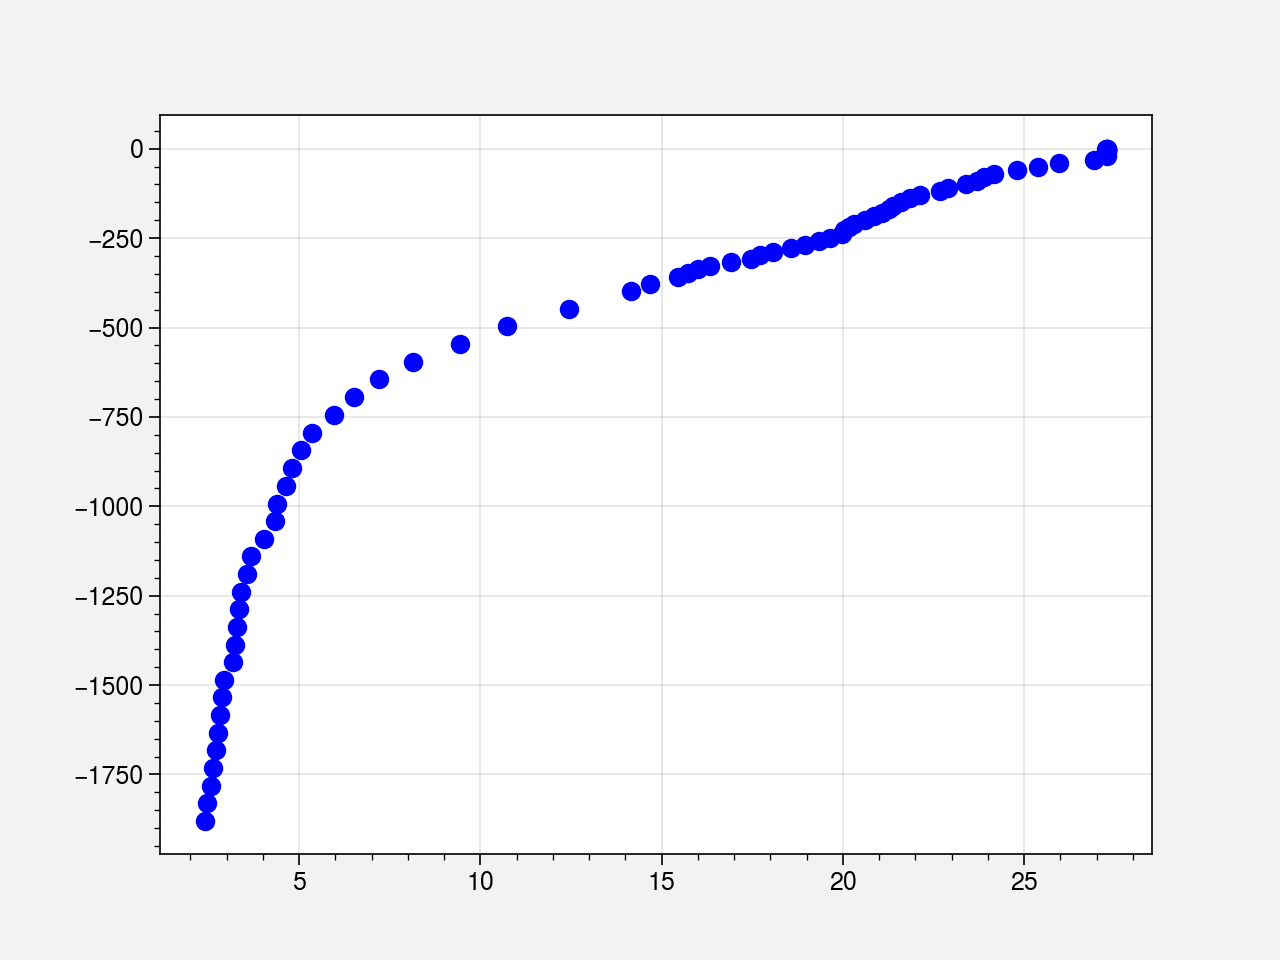

In [88]:
#plt.plot(interp_temperature[0,:],-pressure_levels_interp)

#interp_temperature = interp_to_pressure_levels(temperature_for_casts,temperature_cast_index_for_cast,z_for_casts,z_cast_index_for_cast,pressure_levels_interp)


idx = np.nonzero(temperature_cast_index_for_cast.values==2705)
interp_T = TEOS_10.pchip_interp(z_for_casts[idx],temperature_for_casts[idx],np.arange(2000,-1,-50) )

plt.plot(temperature_for_casts[idx],-z_for_casts[idx],'bo')
#plt.ylim(-250,0)


In [87]:
temperature_for_casts[idx].size

1

In [112]:
import scipy.stats as scipy_stats

longitude_for_casts = data_container_for_year[i_obs_type]['lon'].sel(casts=casts_in_box).values
latitude_for_casts  = data_container_for_year[i_obs_type]['lat'].sel(casts=casts_in_box).values
time_for_casts      = data_container_for_year[i_obs_type]['time'].sel(casts=casts_in_box).values
dayofyear_for_casts = data_container_for_year[i_obs_type]['time'].sel(casts=casts_in_box)['time.dayofyear'].values
#time_range  = np.arange(0,366,1)
date_range  = np.arange(np.datetime64(str(START_YEAR) + "-01-01"), np.datetime64(str(END_YEAR+1) + "-01-01"), np.timedelta64(1, "D"))


LONGITUDE_LIM_WEST = 90
LONGITUDE_LIM_EAST = 180

LATITUDE_LIM_SOUTH = -50
LATITUDE_LIM_NORTH =   0

DELTA_LON = 0.5
DELTA_LAT = 0.5

longitude_grid = np.arange(LONGITUDE_LIM_WEST,LONGITUDE_LIM_EAST+0.5*DELTA_LON,DELTA_LON)
latitude_grid  = np.arange(LATITUDE_LIM_SOUTH,LATITUDE_LIM_NORTH+0.5*DELTA_LAT,DELTA_LON)

#returned_stats = scipy_stats.binned_statistic_dd(np.vstack([dayofyear_for_casts,latitude_for_casts,longitude_for_casts]), np.arange(time_for_casts.size),
#                                                 'count', bins=[date_range,latitude_grid,longitude_grid])
returned_stats = scipy_stats.binned_statistic_dd(np.vstack([dayofyear_for_casts,longitude_for_casts, latitude_for_casts]), None, 'count', bins=np.vstack([time_range,longitude_grid, latitude_grid]))


dsa
#for iT in range(0,date_range.size-1):
#    idx_data_in_time_slice  = np.nonzero(np.logical_and(time_for_casts>=date_range[iT],time_for_casts<date_range[iT+1]) ) [0]
#    
 #   if idx_data_in_time_slice.size !=0:
 #       time_data_in_time_slice = time_for_casts[idx_data_in_time_slice]
 #       lon_data_in_time_slice  = longitude_for_casts[idx_data_in_time_slice]
 #       lat_data_in_time_slice  = latitude_for_casts[idx_data_in_time_slice]
 #       
        
        #lon_bin_index  = np.digitize(lon_data_in_time_slice, bins=longitude_grid)

        
#        dsdsad
        
#ret = stats.binned_statistic_dd(data, np.arange(600), bins=[x, y],

#                                statistic='count')

#returned_stats = scipy_stats.binned_statistic_2d( np.concatenate([time_for_casts,latitude_for_casts,longitude_for_casts]), None, 'count', bins=[time_range, latitude_grid,longitude_grid])
 

NameError: name 'dsa' is not defined

In [131]:
returned_stats = scipy_stats.binned_statistic_dd(np.vstack([dayofyear_for_casts,longitude_for_casts, latitude_for_casts]).T, None, 'count', bins=[time_range,longitude_grid, latitude_grid])


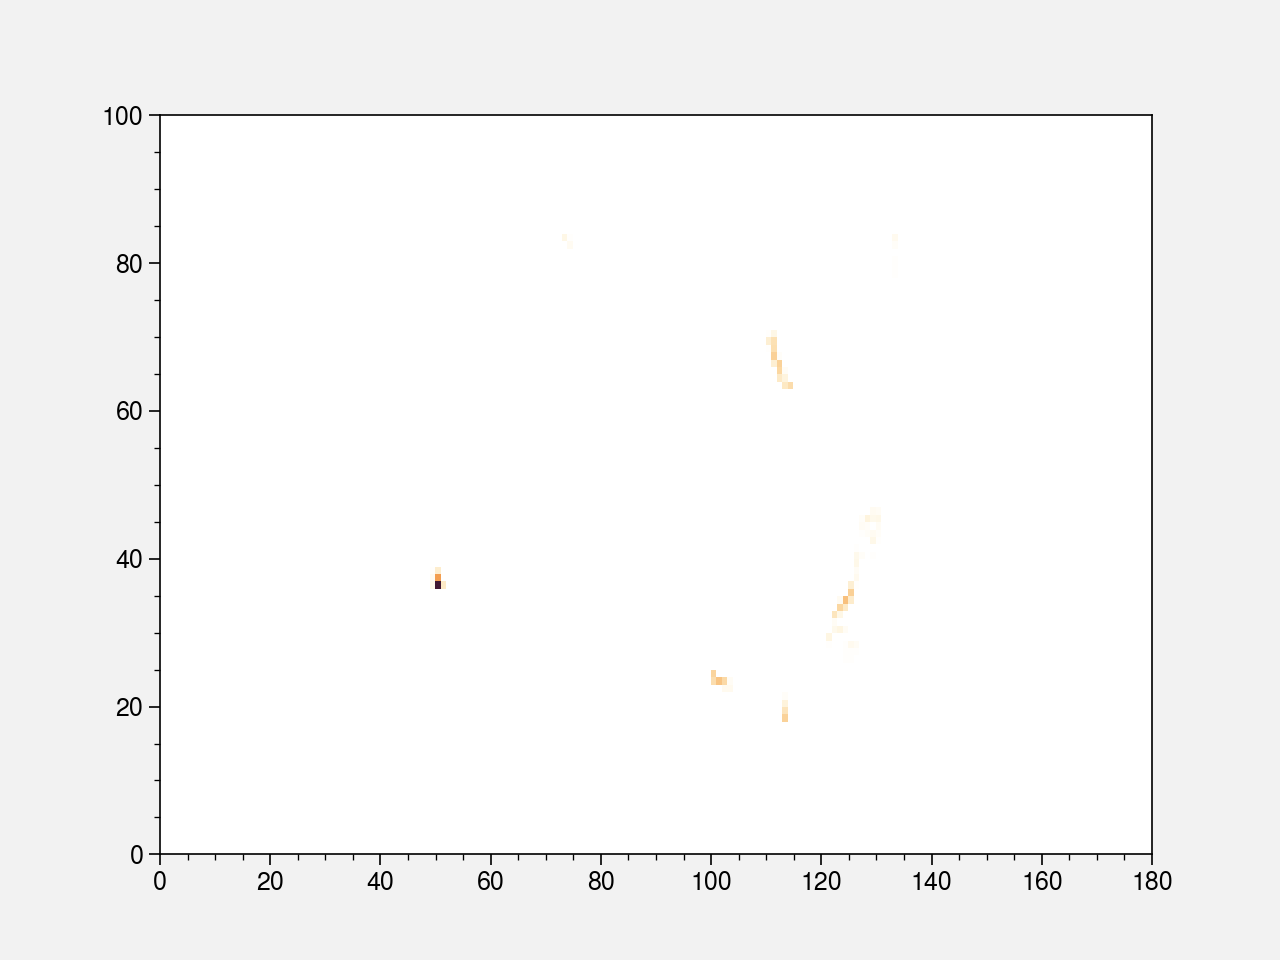

In [135]:
plt.pcolormesh(returned_stats.statistic.sum(axis=0).T)

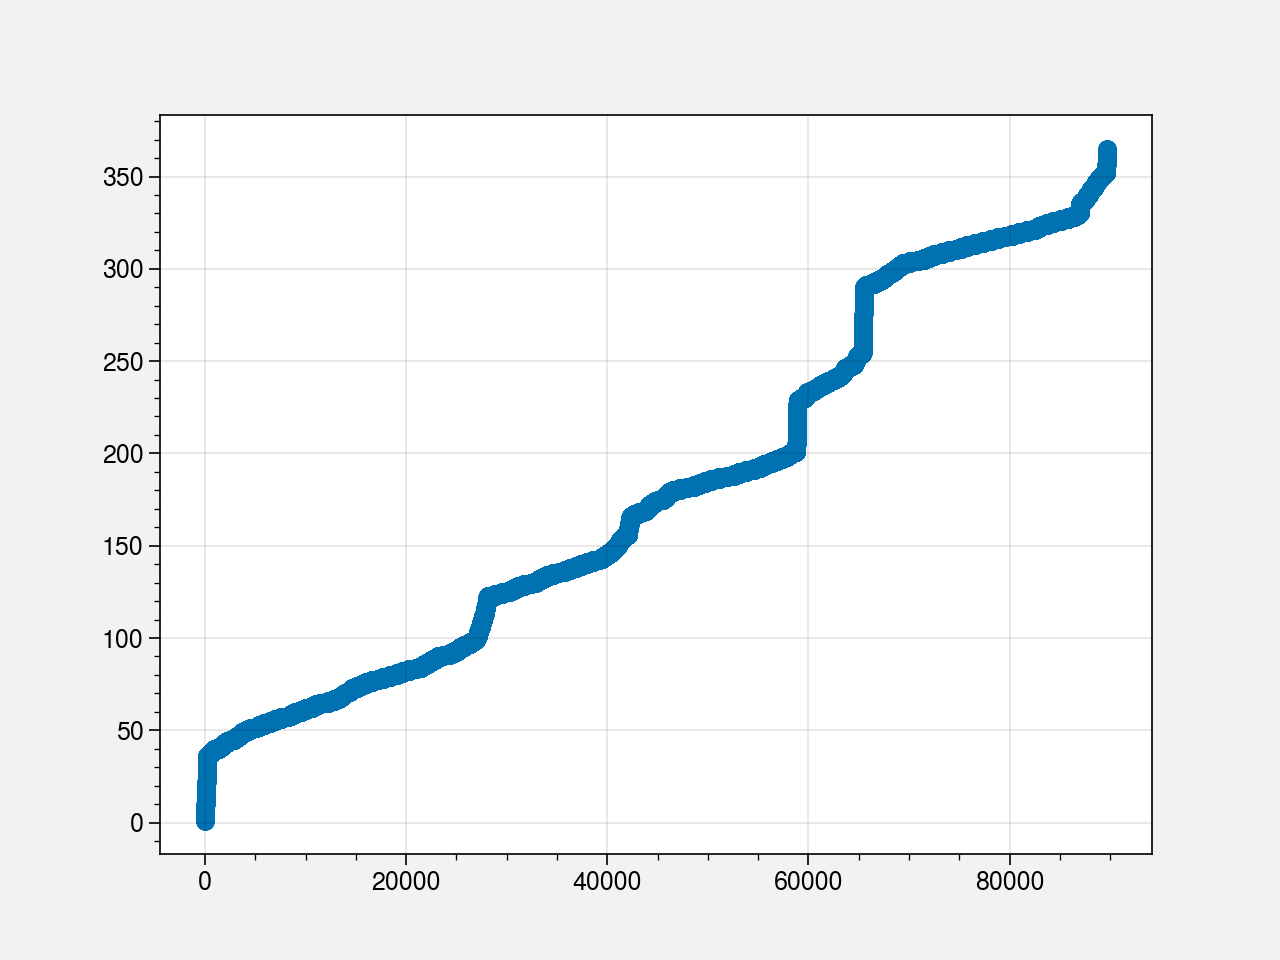

In [110]:
plt.scatter(np.arange(dayofyear_for_casts.size),dayofyear_for_casts)

In [137]:
returned_stats.binnumber.shape

(89687,)

In [59]:
returned_stats = scipy_stats.binned_statistic_dd( np.vstack([dayofyear_for_casts.values,latitude_for_casts.values,longitude_for_casts.values]).T, None, 'count', bins=[time_range, latitude_grid,longitude_grid])


array([180.])

In [42]:
np.vstack([dayofyear_for_casts,latitude_for_casts,longitude_for_casts]).shape

(3, 89687)

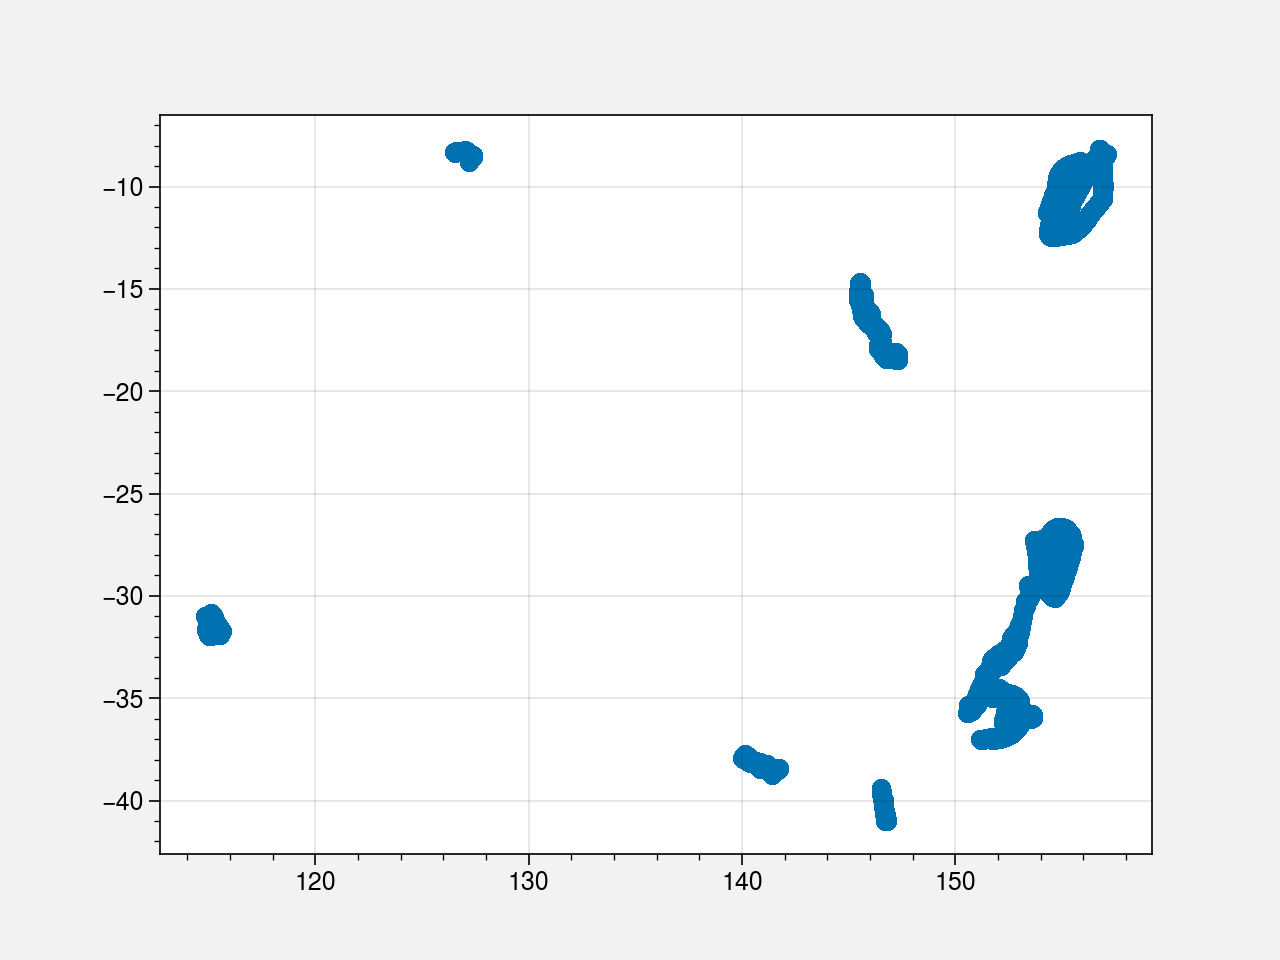

In [16]:
plt.scatter(longitude_for_casts,latitude_for_casts)

In [20]:
longitude_for_casts.shape

(19677273,)

In [8]:
casts_in_box

ValueError: zero-size array to reduction operation maximum which has no identity

<xarray.DataArray 'casts' (casts: 0)>
array([], dtype=int64)
Coordinates:
    lat      (casts) float32 
    lon      (casts) float32 
    time     (casts) datetime64[ns] ...
Dimensions without coordinates: casts

In [9]:
print(z_for_casts.shape)
print(temperature_for_casts.shape)

(430933,)
(430933,)


In [13]:
latitude_for_casts['Temperature_obs'].values

array([     0,      1,      2, ..., 430930, 430931, 430932])

In [38]:
max_depth = 5

idx = np.nonzero(z_for_casts.values<max_depth)[0]
z_near_surface_2 = z_for_casts[idx]
#z_near_surface = z_for_casts.where(z_for_casts<max_depth,drop=True)
T_near_surface = temperature_for_casts[idx]

#temperature_cast_index_for_cast    = data_container_for_year[i_obs_type]['Temperature_cast_index'][temperature_casts_to_get]



In [39]:
T_near_surface

<xarray.DataArray 'Temperature' (Temperature_obs: 1703)>
array([10.637, 13.293, 13.288, ..., 13.449, 13.449, 13.449], dtype=float32)
Dimensions without coordinates: Temperature_obs
Attributes:
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degree_C
    grid_mapping:         crs
    ancillary_variables:  Temperature_sigfigs Temperature_WODflag Temperature...

In [ ]:
z_near_surface_2
z_near_surface